# Introduction #

In this tutorial, we're going to build a simple deep learning model to solve crop classification task using satellite images. This notebook demonstrates the easy steps needed to be done in order to build a crop classification model starting from data preprocessing, model training, to making predictions.

## Crop Classification as a Machine Learning Problem ##

There are multiple ways to formulate the crop classification into a machine learning problem. However, the most commonly used one(especially when you use deep learning models) is to look at it as an image segmentation problem where you assign a class to each pixel of the image within the area of interest and each class represents a specific crop type as state in the problem statement.

### Data ###

The dataset you've received contains 2 formats of data: <i>raster</i> and <i>vector</i>.

#### Raster ####
Raster data is all the images taken from Sentinel-2 satellite in the period between Januaray 2020 to December 2021 over the study area. For each date, there are 10 images(.jp2) taken where each represents a wavelength of the signal that the satellite use the measure the earth surface(see the document we provide for detail explanation about each band). Data in these images is going to be used as the input of our ML model.

![Raster data](sample_raster.png)

#### Vector ####
Vector data contains information about farm boundaries which will help you to locate farms on the satellite image so that you can pick relevant region to extract features from them. Each farm in training data will have a `crop_type` column attach to it, this column indicates the type of plants that is grew in that farm so that you can use them to training and optimizing your ML model.

![Vector data](sample_vector.png)

To work with geospatial data in Python, there are 2 libraries that are very handy: [`rasterio`](https://rasterio.readthedocs.io/en/latest/index.html) and [`geopandas`](https://geopandas.org/en/stable/index.html). `Rasterio` provides functions to manipulate the satellite image files and vector data while `Geopandas` makes dealing with the ground data become much easier. The code below shows how you can use these 2 libraries to explore and manipulate the data.


Dataset profile : {'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': 0.0, 'width': 2051, 'height': 2051, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(10.0, 0.0, 754360.0,
       0.0, -10.0, 1688690.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


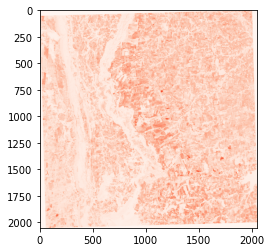

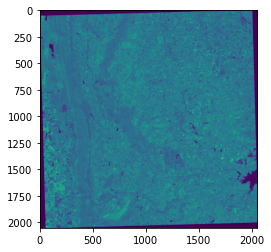

In [8]:
# Working with raster data
import rasterio
import matplotlib.pyplot as plt

# Open image files
R_dataset = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2')
NIR_dataset = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B08.jp2')
print(f'Dataset profile : {R_dataset.profile}') # `profile` contains metadata about an image such as dimension, number of channels, and co-ordinate reference system 

# Read image data from dataset
R = R_dataset.read()[0]       # Read raster data from dataset, the array size will be equal to dimension in the dataset profile
NIR = NIR_dataset.read()[0]

plt.figure()
plt.imshow(R, cmap='Reds')
plt.figure()
plt.imshow(NIR)

  years crop_type                                           geometry
0  2021         1  POLYGON ((101.55476 15.10233, 101.55479 15.103...
1  2021         1  POLYGON ((101.54317 15.09377, 101.54337 15.094...
2  2021         1  POLYGON ((101.52758 15.12749, 101.52815 15.129...
3  2021         3  POLYGON ((101.52441 15.12918, 101.52553 15.129...
4  2021         2  POLYGON ((101.45462 15.16983, 101.45582 15.169...
           geometry
crop_type          
1               510
2               240
3               433
4               134


<AxesSubplot:>

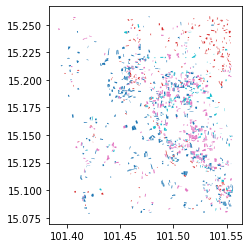

In [2]:
# Working with vector data
import geopandas

ground_truth = geopandas.read_file('data/raw/shape/training_area/train_data.shp')
print(ground_truth.head())                                                    # See sample data
print(ground_truth[['crop_type', 'geometry']].groupby(['crop_type']).count()) # Compute class distribution

# Visulize ground data
ground_truth.plot(column='crop_type')

## Pre-processing ##

Now that you have a basic understanding of data content and formats, we can proceed on preparing data for training the ML model.

In this tutorial, we're going to use Normalized Difference Vegetation Index([NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)) as a feature for classifying farm crop type. Here are the steps that we're going to do to prepare the train data:
1. Create monthly-NDVI image.
2. Convert ground truth data into the target image.
3. Split the monthly-NDVI image and the target image into patches.

### Create monthly-NDVI image ###

NDVI is the most widely used vegetation index in remote sensing as a measurement of plant health. In this example, we hypothesize that each crop type(rice, maize, casava, and sugarcane) has its own NDVI pattern. Therefore, we're going to compute NDVI of each month, stack them together, and use them as an input to the ML model.

Text(0.5, 1.0, 'MAY')

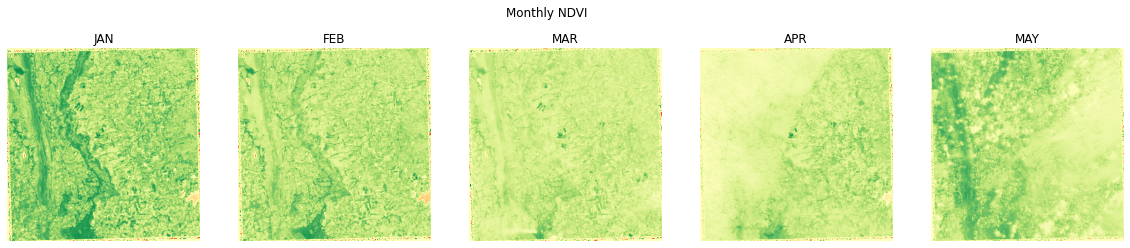

In [17]:
import numpy as np

# List of input files
file_templates = [
    'data/raw/image/20210101/IMG_DATA/47PQS_20210101_{0}.jp2',
    'data/raw/image/20210205/IMG_DATA/47PQS_20210205_{0}.jp2',
    'data/raw/image/20210302/IMG_DATA/47PQS_20210302_{0}.jp2',
    'data/raw/image/20210401/IMG_DATA/47PQS_20210401_{0}.jp2',
    'data/raw/image/20210501/IMG_DATA/47PQS_20210501_{0}.jp2',
]
ndvi_images = []

# Read B04 and B08 data, then construct NDVI image for each date
for template in file_templates:
    R = rasterio.open(template.format('B04')).read(1).astype(float)
    NIR = rasterio.open(template.format('B08')).read(1).astype(float)
    NDVI = np.divide(NIR - R, NIR + R, out=np.zeros_like(R), where=(NIR + R) != 0)
    ndvi_images.append(NDVI)

# Combine all NDVI images into a single multi-channel image where each channel represents NDVI of a specific month in ascending order
monthly_ndvi = np.stack(ndvi_images)

plt.figure(figsize=(20,4))
plt.suptitle('Monthly NDVI')
plt.subplot(151)
plt.imshow(monthly_ndvi[0], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('JAN')
plt.subplot(152)
plt.imshow(monthly_ndvi[1], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('FEB')
plt.subplot(153)
plt.imshow(monthly_ndvi[2], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('MAR')
plt.subplot(154)
plt.imshow(monthly_ndvi[3], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('APR')
plt.subplot(155)
plt.imshow(monthly_ndvi[4], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.title('MAY')

### Convert ground truth data into the target image. ##

After making the input image, we need the target image that we want the model to predict. The ground data, however, is in the vector format so it can't be used directly. Luckily, there is a way to convert vector data into image using `rasterio` and `geopandas`.

`rasterio.features` package provides the `rasterize` method that burn geometry vectors into an image with specific dimension and co-ordinate reference system. All you need to do is to pass in the list of tuple containing a polygon and value associated to it along with the transformation matrix of the resulting image. The code below show you how to do it.

Class pixel count: {1: 100162, 2: 29069, 3: 84342, 4: 23309}


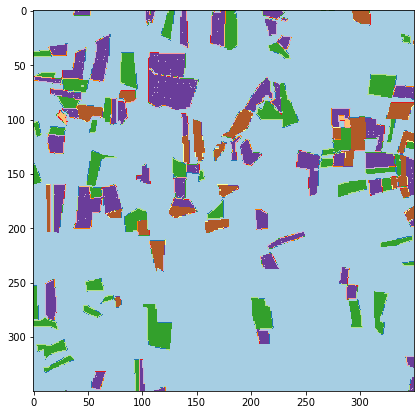

In [46]:
from rasterio.features import rasterize

img_profile = rasterio.open('data/raw/image/20210101/IMG_DATA/47PQS_20210101_B04.jp2').profile
label = geopandas.read_file('data/raw/shape/training_area/train_data.shp').to_crs(img_profile['crs'])
target_image = rasterize(
    shapes=[(row.geometry, int(row.crop_type)) for i, row in label.iterrows()], # Construct polygon and value tuples
    out_shape=(img_profile['width'], img_profile['height']),
    transform=img_profile['transform']                                          # This will make every pixel in the target image align correctly with satellite image
)
classes, pixel_counts = np.unique(target_image, return_counts=True)
print('Class pixel count: ' + str(dict(zip(classes[1:], pixel_counts[1:]))))
plt.figure(figsize=(7,7))
plt.imshow(target_image[750:1100, 1250:1600], cmap='Paired')

### Split the monthly-NDVI image and the target image into patches. ###

Now we already have input and target images. However, the size of both are extremely large(~2000 x 2000 = 4 millions pixels). This is problematic because not only the training process will be inefficient but also the model convergence will be extremely slow.

The simplest approach to circumvent this issue is to split the image into small patches and train the model on them instead of the original large image. `scikit-learn`(the most popular Python machine learning library) provides the `extract_patches_2d` function that does what we want exactly.

(10000, 5, 64, 64)
(10000, 64, 64)


(-0.5, 63.5, 63.5, -0.5)

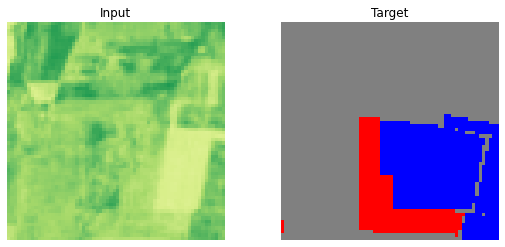

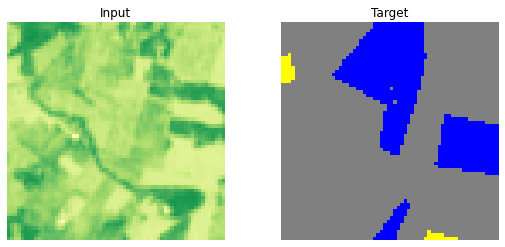

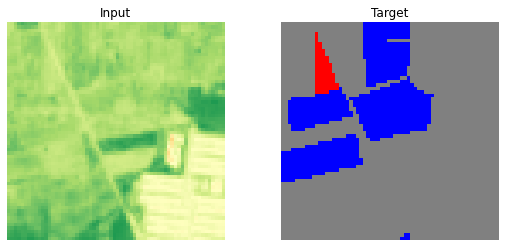

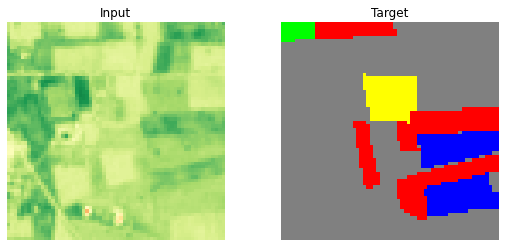

In [186]:
from sklearn.feature_extraction.image import extract_patches_2d

# Define patch size
PATCH_HEIGHT = 64
PATCH_WIDTH = 64

# Set the random_state so that both input and target images are splitted at the similar location
ndvi_patches = extract_patches_2d(monthly_ndvi.transpose(1,2,0), patch_size=(PATCH_HEIGHT,PATCH_WIDTH), max_patches=10000, random_state=15)
ndvi_patches = ndvi_patches.transpose((0,3,1,2))
target_patches = extract_patches_2d(target_image, patch_size=(PATCH_HEIGHT,PATCH_WIDTH), max_patches=10000, random_state=15)

print(ndvi_patches.shape)
print(target_patches.shape)

# Visualize splitted input and target
color_map = {0: np.array([128, 128, 128]), # Unknown, gray
             1: np.array([255, 0, 0]),     # Cassava, red
             2: np.array([0, 255, 0]),     # Maize, green
             3: np.array([0, 0, 255]),     # Rice, blue 
             4: np.array([255, 255, 0])}   # Sugarcane, yellow

def assign_class_color(class_map):
    output = np.zeros((class_map.shape[0], class_map.shape[1], 3), dtype=int)
    for i in range(class_map.shape[0]):
        for j in range(class_map.shape[1]):
            output[i][j] = color_map[class_map[i][j]]

    return output

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.title('Input')
plt.imshow(ndvi_patches[1001,0], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.subplot(122)
plt.title('Target')
plt.imshow(assign_class_color(target_patches[1001]), cmap='Paired')
plt.axis('off')
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.title('Input')
plt.imshow(ndvi_patches[7616,0], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.subplot(122)
plt.title('Target')
plt.imshow(assign_class_color(target_patches[7616]), cmap='Paired')
plt.axis('off')
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.title('Input')
plt.imshow(ndvi_patches[796,0], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.subplot(122)
plt.title('Target')
plt.imshow(assign_class_color(target_patches[796]), cmap='Paired')
plt.axis('off')
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.title('Input')
plt.imshow(ndvi_patches[347,0], cmap='RdYlGn', vmin=-1, vmax=1)
plt.axis('off')
plt.subplot(122)
plt.title('Target')
plt.imshow(assign_class_color(target_patches[347]), cmap='Paired')
plt.axis('off')

## Model Training ##

We've finished preprocessing the data and manipulated them into an easy-to-use format. Therefore, we can start developing and training our deep learning model.

### Defining the model ###

We're going to use a simple fully convultional neural network as the model architechture. 

<i>Fully Convolutional Neural Network(FCN)</i> is a neural network that only consists of convolutional layers. This architechture is the key principle behinds many state-of-the-art image segmentation model. The details about FCN is beyond the scope of this tutorial, but, if you're interested, there are plenty of resources about [FCN](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf) available online.

In this example, our model uses encoder-decoder FCN architecture with 2 downsampling and upsampling layers respectively with ReLU as an activation function which defined as follow:

In [135]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import *
from torch.nn.functional import relu

class FCN(Module):
    def __init__(self, in_channels, n_classes):
        super(FCN, self).__init__()
        self.conv1 = Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = MaxPool2d((2,2))
        self.conv2 = Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.maxpool2 = MaxPool2d((2,2))
        self.tconv1 = ConvTranspose2d(in_channels=32, out_channels=16, stride=2, kernel_size=5, padding=2, output_padding=1)
        self.tconv2 = ConvTranspose2d(in_channels=16, out_channels=n_classes, stride=2, kernel_size=3, padding=1, output_padding=1)

    def forward(self, x):
        out = relu(self.conv1(x))
        out = self.maxpool1(out)
        out = relu(self.conv2(out))
        out = self.maxpool2(out)
        out = relu(self.tconv1(out))
        out = self.tconv2(out)
        
        return out

### Model Training ###

The model is trained with Cross-entropy loss function as the problem contains multiple classes. Model's parameters are optimized using Adam gradient descent algorithm for 10 epochs with a batch size of 32.

Text(0, 0.5, 'Loss')

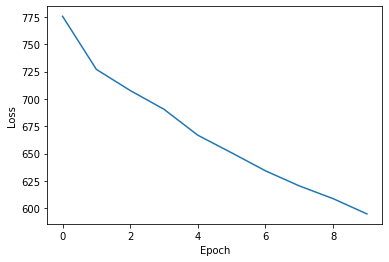

In [171]:
BATCH_SIZE = 32
EPOCHS = 10
N_CLASSES = 5
N_CHANNELS = 5

model = FCN(in_channels=N_CHANNELS, n_classes=N_CLASSES)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_set = TensorDataset(torch.tensor(ndvi_patches).float(), torch.tensor(target_patches).long())
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
ep_losses = []

for ep in range(EPOCHS):
    ep_loss = 0.
    for x, y in train_loader:
        optimizer.zero_grad()
        predict = model(x)
        loss = criterion(predict, y)
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
    ep_losses.append(ep_loss)
    # print(f'Ep {ep + 1} Loss : {ep_loss}')

plt.plot(range(EPOCHS), ep_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

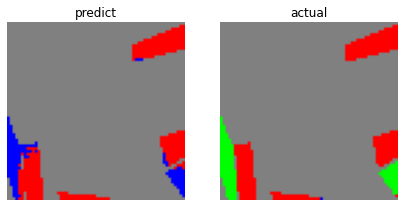

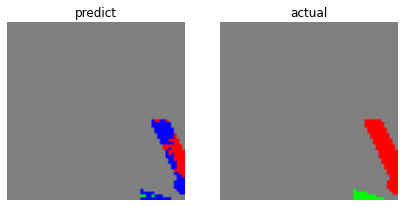

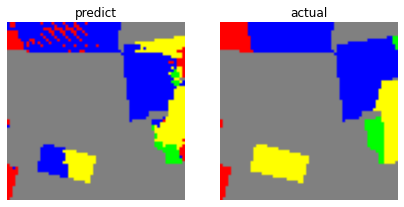

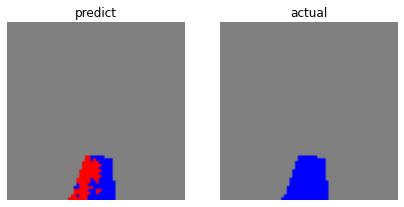

In [194]:
# Sample output
model.eval()
x, y = next(iter(train_loader))
predict = model(x).argmax(dim=1)

for i in range(5):
    
    if y[i].count_nonzero() == 0: continue
    
    plt.figure(figsize=(7,4))
    plt.subplot(121)
    plt.imshow(assign_class_color(predict[i].detach().numpy() * (y[i].detach().numpy() != 0).astype(int))) # Only show pixels inside ground data polygons
    plt.title('predict')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(assign_class_color(y[i].detach().numpy()))
    plt.title('actual')
    plt.axis('off')